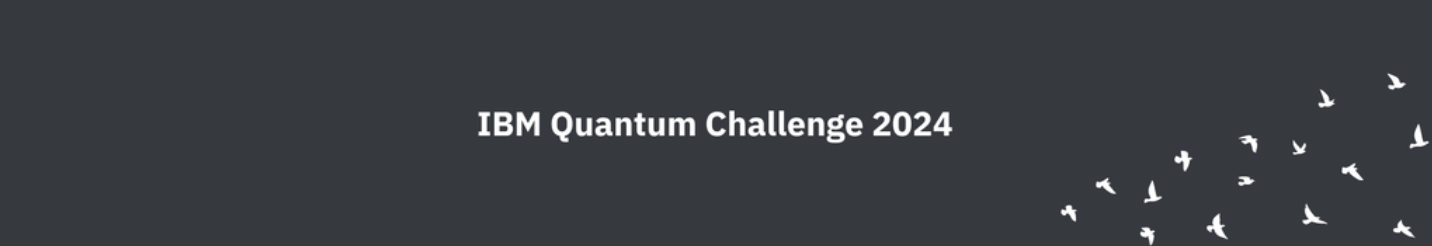

In [8]:
# imports
import numpy as np
from typing import List, Callable
from scipy.optimize import minimize
from scipy.optimize._optimize import OptimizeResult
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob, PrimitiveResult
from qiskit.circuit.library import EfficientSU2, TwoLocal
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers import BackendV2
from qiskit.visualization import plot_histogram

from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeKyoto
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator, SamplerV2 as Sampler

from qiskit_aer import AerSimulator

In [2]:
# For Testing purposes. Will remove for the final version

# This is required during testing phase. If you see the following error message:
# Failed: {'errors': [{'message': 'The challenge is not active', 'extensions': {'code': 'INVALID_QUERY'}}]}
# Restart the kernel and run this cell
%set_env QC_GRADE_ONLY=true

# If you see the following error message:
# Failed: Unable to access service (Forbidden)
# Uncomment the line below and copy and past your IBM Quantum token. See lab 0 for more detailed instructions
%set_env QXToken=d81f361c8a481831e8a325c6dfd012ff62179c13368cd16b4049dd4ce2958000b8c5126523b1c99079aad7d6829bfda5e3d231dc3e7814c4db04ca4806d81a29

env: QC_GRADE_ONLY=true
env: QXToken=d81f361c8a481831e8a325c6dfd012ff62179c13368cd16b4049dd4ce2958000b8c5126523b1c99079aad7d6829bfda5e3d231dc3e7814c4db04ca4806d81a29


In [3]:
from qc_grader.challenges.iqc_2024 import (
    grade_lab1_ex1,
    grade_lab1_ex2,
    grade_lab1_ex3,
    grade_lab1_ex4,
    grade_lab1_ex5,
    grade_lab1_ex6,
    grade_lab1_ex7,
)

# Challenge One: Introduction to Qiskit 1.0

# Table of Contents
- **[Introduction](##Introduction)**
- **[Part I: Qiskit states, the new and the old](#Part-I:-Qiskit-states,-the-new-and-the-old)**
    - **[Exercise 1: Create and draw a singlet Bell state circuit](#exercise1)**
    - **[Exercise 2: Use Sampler.run](#exercise2)**
    - **[Exercise 3: Create and draw a W-state circuit](#exercise3)**    
- **[Part II: VQE with Qiskit 1.0](#Part-II:-VQE-with-Qiskit-1.0)**
    - **[Exercise 4: Create a parameterized circuit to serve as the ansatz](#exercise4)**    
    - **[Exercise 5: Transpile to ISA circuits](#exercise5)**  
    - **[Exercise 6: Defining the cost function](#exercise6)**  
    - **[Exercise 7: QiskitRuntimeService V2 Primitives, local testing mode and Sessions, a first look](#exercise7)**


## Introduction

Welcome to Challenge one! This first challenge is designed to introduce you to some of the new capabilities and functions of Qiskit 1.0. Later challenges will develop on these capabilities further and introduce the more complex new Qiskit functionalities.
Through this challenge you will re-learn how to set up quantum states using qiskit, and how to implement an optimization algorithm using VQE. These two tasks will be set in two sections: 

1) Qiskit states, the new and the old 
2) VQE with Qiskit 1.0

Let's get started!

## Part I: Qiskit states, the new and the old

<a id="exercise1"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 1: Create and draw a singlet Bell state circuit</b> 
    
Bell circuits are specific circuits wich generate Bell states or EPR pairs, a form of entangled and normalized basis vectors. In other words, they are the circuits we use to generate entangled states, a key property of qubits.
These circuits are considered easy to design. There exist 4 different Bell states, please build a circuit that generates the |ϕ-> bell state. 
    
</div>

In [4]:
# Make a quantum circuit
qc = QuantumCircuit(2)
# Apply gates to form a Bell state 
#
#
# build your code here
qc.x(1)
qc.h(0)
qc.z(0)
qc.z(1)
# Perform a CNOT gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
#
#

In [5]:
# Submit your answer using following code

grade_lab1_ex1(qc) # Expected result type: QuantumCircuit

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


To observe the resulting entangled state of our circuit, we process our circuit and output the result counts. Here is some basic code on how you can do this:

<a id="exercise2"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 2: Use Sampler.run</b> 
    
[Qiskit Runtime Sampler](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.SamplerV2) [primitive](https://docs.quantum.ibm.com/run/primitives-get-started) returns the sampled result according to the specified output type. It allows us to efficiently sample quantum states by executing quantum circuits and providing probability distributions of the quantum states. In this exercise we will use the Qiskit Sampler to obtain the counts resulting from our circuit.
    
</div>

In [10]:
qc.measure_all()

sampler = StatevectorSampler()
pub = (qc) 
job_sampler = sampler.run([pub])


result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'01': 520, '10': 504}


In [11]:
# Submit your answer using following code

grade_lab1_ex2(job_sampler) # Expected result type: PrimitiveJob

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


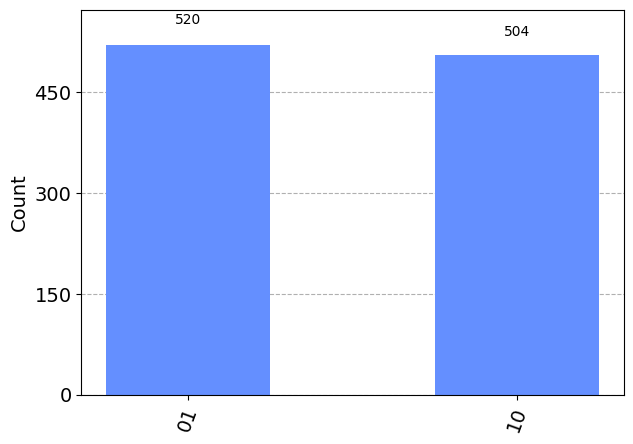

In [12]:
plot_histogram(counts_sampler)

As you can see we approximately get a 50/50 distribution of our resulting qubits in a 01 or 10 state, signaling that entanglement was performed as expected.

<a id="exercise3"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 3: Create and draw a W-state circuit</b> 
    
Next, we will develop a slightly more complicated circuit. Similarly to Bell states circuit producing Bell states, W-state circuits produce W states. Although Bell states entangle two qubits, W-states entangle three qubits.
To build our W-state, we will follow 5 simple steps:
1) We will initialize our 3 qubit circuit
2) Then we will perform an Ry rotation on our qubit. The specifics are this operation are provided.
3) We will perform a controlled hadamard gate on qubit 1, with control qubit 0
4) We will add a CNOT gate with control qubit 1 and target qubit 2
5) We will add a X gate on qubit 0
    
</div>

In [15]:
qc = QuantumCircuit(3) # Initialize our 3 qubit circuit
qc.ry(1.91063324, 0) # Perform an Ry rotation on our qubit

#Add your code step 3-5
#
#
qc.ch(0,1)
qc.cx(1,2)
qc.cx(0,1)
qc.x(0)
#
#

qc.measure_all()

qc.draw()

┌────────────┐               ┌───┐ ░ ┌─┐      
   q_0: ┤ Ry(1.9106) ├──■─────────■──┤ X ├─░─┤M├──────
        └────────────┘┌─┴─┐     ┌─┴─┐└───┘ ░ └╥┘┌─┐   
   q_1: ──────────────┤ H ├──■──┤ X ├──────░──╫─┤M├───
                      └───┘┌─┴─┐└───┘      ░  ║ └╥┘┌─┐
   q_2: ───────────────────┤ X ├───────────░──╫──╫─┤M├
                           └───┘           ░  ║  ║ └╥┘
meas: 3/══════════════════════════════════════╩══╩══╩═
                                              0  1  2

In [16]:
# Submit your answer using following code

grade_lab1_ex3(qc) # Expected result type: # Expected result type: QuantumCircuit

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


Once again, let's visualize our results:

In [17]:
sampler = StatevectorSampler()
pub = (qc)
job_sampler = sampler.run([pub], shots=1000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'100': 317, '010': 327, '001': 356}


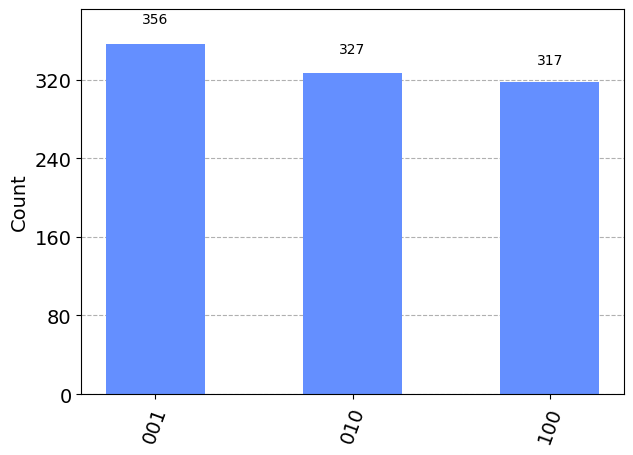

In [18]:
plot_histogram(counts_sampler)

We observe our total counts distributed in 3 similarly sized bins in 3 states, signaling a successfull W state!

Now that we have basic circuits down, we'll start introducing and developping more complex codes with Qiskit 1.0.

## Part II: VQE with Qiskit 1.0

The core of this challenge will leverage Qiskit Runtime and a Variational Quantum Eigensolver (VQE). We will be using the Qiskit Runtime Estimator to calculate expectation values for combinations of qubits, and Qiskit Runtime Sessions to facilitate running a VQE algorithm. The challenge draws upon code from an example that experimental physicist & IBM Quantum researcher Nick Bronn created for the [Coding with Qiskit Runtime video series](https://www.youtube.com/playlist?list=PLOFEBzvs-VvqAC8DnVoLOzg2bKE4C7ARM), specifically in [Episode 05 Primitives & Sessions](https://youtu.be/yxuH8eb4MS4?si=e3trSORNjooWlQXu), and implements it using the newest Qiskit 1.0 version.

### Let's start by creating a Pauli operator
A Pauli operators is a matrix representing a quantum mechanical observable corresponding to a measurement of spin along a particular axis (x,y,z). Let's build one:

In [19]:
pauli_op = SparsePauliOp(['ZII', 'IZI', 'IIZ']) 
print(pauli_op.to_matrix())

[[ 3.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -3.+0.j]]


Feel free to experiment with various Pauli operators and see what resulting possible combinantions you obtain!

### Setup and run a VQE algorithm

Now, we'll start setting up our VQE algorithm. Variational quantum eigensolvers (VQEs), are hybrid algorithms that utilize quantum and classical techniques to find the ground state of a given physical system. They are often used in quantum chemistry and optimization problems, and are promising candidates for hybrid-algorithms in noisy near-term devices.

VQEs are characterized by the use of a classical optimization algorithm to iteratively update a parameterized trial solution, called an "ansatz". The aim is to solve for the ground state of a given Hamiltonian represented as a linear combination of Pauli terms, with an "trial solution" or ansatz circuit where the number of parameters to optimize over is polynomial in the number of qubits. 

Executing a VQE algorithm requires the 3 steps:

1) Setting up the Hamiltonian and ansatz (problem specification)
2) Implementing the Qiskit Runtime estimator
3) Adding the Classical optimizer and running our program

We we will follow these steps.

<a id="exercise4"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 4: Create a parameterized circuit to serve as the ansatz</b> 
    
Our first task will be to set up our ansatz aka a trial solution for our problem, that we will "perfect"/"compare against".
In order to do this we will can use Qiskit's TwoLocal circuit, a pre-built circuit that can be used to prepare trial wave functions for variational quantum algorithms or classification circuit for machine learning. TwoLocal circuit are parameterized circuits consisting of alternating rotation layers and entanglement layers. You can find more information about them in [Qiskit's documentation](https://docs.quantum.ibm.com/api/qiskit/circuit_library).
In this task, you will set up a 3 qubit TwoLocal circuit using [Ry](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RYGate) and [Rz](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RZGate) rotations.    

</div>

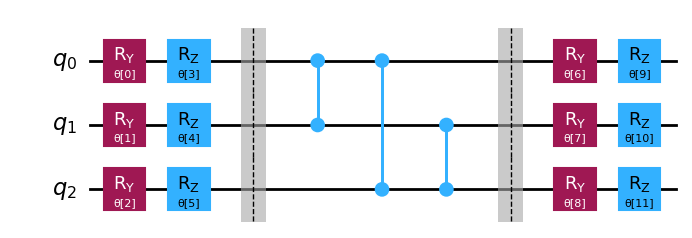

In [27]:
num_qubits = 3
rotation_blocks = ['ry','rz']
entanglement_blocks = 'cz'
entanglement = 'full'

ansatz = TwoLocal(num_qubits, rotation_blocks, entanglement_blocks, entanglement, reps=1, insert_barriers=True)
ansatz.decompose().draw('mpl')

In [28]:
# Submit your answer using following code

grade_lab1_ex4(num_qubits, rotation_blocks, entanglement_blocks, entanglement) # Expected result type: int, List[str], str, str

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


From the previous figure we see that our ansatz circuit is defined by a vector of parameters θ, with the total number given by:

In [29]:
num_params = ansatz.num_parameters
num_params

12

<a id="exercise5"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 5: Transpile to ISA circuits </b> 
    
In this example we will use the [AerSimulator](https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.AerSimulator.html), a noisy quantum circuit simulator backend which supports multiple simulation methods.    

</div>

In [30]:
aer_sim = AerSimulator()

Preset pass managers are the default pass managers used by the transpile() function. transpile() provides a convenient and simple method to construct a standalone PassManager object that mirrors what the transpile. For this next task you will define the pass manager are the default pass managers used by the transpile() function. Check the [Qiskit documentation](https://docs.quantum.ibm.com/api/qiskit/0.42/qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager) for more info.

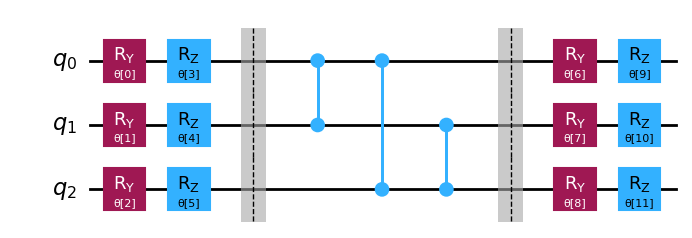

In [63]:
backend_answer = aer_sim
optimization_level_answer = 3
pm = generate_preset_pass_manager(backend=backend_answer,optimization_level=optimization_level_answer) 
# added below myself
isa_circuit = pm.run(ansatz)
isa_circuit.draw('mpl')

In [55]:
# Submit your answer using following code

grade_lab1_ex5(isa_circuit) # Expected result type: QuantumCircuit

Grading your answer. Please wait...

Oops 😕! circuit has not been mapped to the entire device
Please review your answer and try again.


With the newest version of Qiskit Runtime, all circuits submitted to a backend must conform to the constraints of the backend’s Target. Such circuits are considered to be written in terms of that backend’s Instruction Set Architecture ([ISA](https://www.ibm.com/quantum/blog/isa-circuits?social_post=sf187802680&sf187802680=1)) — i.e., the set of instructions the device can understand and execute. These Target constraints are defined by factors like the device’s native basis gates, its qubit connectivity, and when relevant, its pulse and other instruction timing specifications.
To define our ISA circuits we will run:

In [38]:
isa_circuit.draw(idle_wires=False)

┌──────────┐┌──────────┐ ░           ░ ┌──────────┐ ┌──────────┐
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├─░──■──■─────░─┤ Ry(θ[6]) ├─┤ Rz(θ[9]) ├
     ├──────────┤├──────────┤ ░  │  │     ░ ├──────────┤┌┴──────────┤
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├─░──■──┼──■──░─┤ Ry(θ[7]) ├┤ Rz(θ[10]) ├
     ├──────────┤├──────────┤ ░     │  │  ░ ├──────────┤├───────────┤
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├─░─────■──■──░─┤ Ry(θ[8]) ├┤ Rz(θ[11]) ├
     └──────────┘└──────────┘ ░           ░ └──────────┘└───────────┘

In [39]:
ansatz.decompose().count_ops()

OrderedDict([('ry', 6), ('rz', 6), ('cz', 3), ('barrier', 2)])

In [40]:
isa_circuit.count_ops()

OrderedDict([('ry', 6), ('rz', 6), ('cz', 3), ('barrier', 2)])

Traditionally VQEs stream to resolve the electronic structure of a [Hamiltonian](https://materialstheory.springeropen.com/articles/10.1186/s41313-021-00032-6). We will use our previosuly defined Pauli operators to define our Hamiltonian:

In [64]:
hamiltonian_isa = pauli_op.apply_layout(layout=isa_circuit.layout)
hamiltonian_isa

SparsePauliOp(['ZII', 'IZI', 'IIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j])

<a id="exercise6"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 6: Defining the cost function </b> 
    
Like many classical optimization problems, the solution to a VQE problem can be formulated as minimization of a scalar cost function. With the Qiskit Runtime Estimator  directly taking a Hamiltonian and parameterized ansatz, and returning the necessary energy, the cost function for a VQE instance is quite simple:   

</div>

In [59]:
def cost_func(params, ansatz, hamiltonian, estimator, callback_dict):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])#Add your code
    result = estimator.run(pubs=[pub]).result()#Add your code
    energy = result[0].data.evs[0]#Add your code

    callback_dict["iters"] += 1 #Add your code
    callback_dict["prev_vector"] = params#Add your code
    callback_dict["cost_history"].append(energy) #Add your code

    print(energy)

    return energy, result

In [60]:
# Submit your answer using following code

grade_lab1_ex6(cost_func) # Expected result type: Callable

[0.64453125]
Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


Callback functions are a standard way for users to obtain additional information about the status of an iterative algorithm (such as VQE). However, it is possible to do much more than this. Here, we use a mutable object (dictionary), to store resulting vector at each iteration of our algorithm, in case we need to restart the routine due to failure or return the another iteration number.

In [89]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

### Using the Classical Optimizer

We can now use a classical optimizer of our choice to minimize the cost function.
In real quantum hardware, the choice of optimizer is important, as not all optimizers handle noisy cost function landscapes equally well. Here, we can use SciPy routines.

To begin the routine, we specify a random initial set of parameters:

In [62]:
x0 = 2 * np.pi * np.random.random(num_params) 
x0

array([3.68009223, 6.09438783, 3.93290994, 4.26895475, 2.26561564,
       2.22513737, 1.77906484, 5.58157161, 1.28017549, 1.9030653 ,
       5.13742178, 5.06167117])

<a id="exercise7"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 7: QiskitRuntimeService V2 Primitives, local testing mode and Sessions, a first look </b> 
    
Next, we will use the new QiskitRuntimeService [V2 primitives](https://docs.quantum.ibm.com/api/migration-guides/v2-primitives): [EstimatorV2](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) and [SamplerV2](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.SamplerV2). 

The new Estimator interface lets you specify a single circuit and multiple observables and parameter value sets for that circuit, so that sweeps over parameter value sets and observables can be efficiently specified. Previously, you had to specify the same circuit multiple times to match the size of the data to be combined. Also, while you can still use optimization_level and resilience_level as the simple knobs, V2 primitives give you the flexibility to turn on or off individual error mitigation / suppression methods to customize them for your needs.

Sampler V2 is simplified to focus on its core task of sampling the output register from execution of quantum circuits. It returns the samples, whose type is defined by the program, without weights. The output data is also separated by the output register names defined by the program. This change enables future support for circuits with classical control flow.

We will also use Qiskit's 1.0 [local testing mode](https://docs.quantum.ibm.com/verify/local-testing-mode). Local testing mode (available with qiskit-ibm-runtime 0.22.0 or later) can be used to help develop and test programs before fine-tuning them and sending them to real quantum hardware. After using local testing mode to verify your program, all you need to change is the backend name to run it on an IBM Quantum system.

</div>

In [90]:
# Use fake ibm backend to simulate with noise that matches closer to the real experiment. This will run slower.
# If you want to run faster, try to use AerSimulator without noise to quickly iterate and find out your answer.
backend = AerSimulator() 
#backend = FakeKyoto()

# update cost function to return only the energy to be compatible with recent scipy versions (>=1.10)
def cost_func_2(*args, **kwargs):
    energy, result = cost_func(*args, **kwargs)
    return energy

with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 1000

    res = minimize(
        cost_func_2, 
        x0, 
        args=(isa_circuit, hamiltonian_isa, estimator, callback_dict), 
        method="cobyla",
        #updated to 100 iterations instead of 30
        options={'maxiter': 100})


1.2802734375
0.8583984375
0.5
0.548828125
0.0556640625
0.0986328125
0.052734375
0.263671875
0.25537109375
0.75048828125
0.0556640625
0.11279296875
0.11181640625
-0.5146484375
-0.94140625
-1.05322265625
-0.72607421875
-1.32958984375
-0.69384765625
-1.291015625
-0.96435546875
-1.23388671875
-0.736328125
-1.3193359375
-1.28515625
-1.30029296875
-1.98388671875
-2.1142578125
-2.0126953125
-2.38427734375
-1.75634765625
-2.12451171875
-2.01708984375
-2.4228515625
-2.828125
-2.70751953125
-2.8486328125
-2.8525390625
-2.85205078125
-2.46630859375
-2.7529296875
-2.650390625
-2.8173828125
-2.302734375
-2.609375
-2.7001953125
-2.88720703125
-2.91552734375
-2.8359375
-2.90185546875
-2.79296875
-2.83447265625
-2.9501953125
-2.95849609375
-2.91162109375
-2.90771484375
-2.8310546875
-2.93798828125
-2.95556640625
-2.970703125
-2.96435546875
-2.96533203125
-2.98974609375
-2.9716796875
-2.98388671875
-2.98681640625
-2.97021484375
-2.98291015625
-2.9931640625
-2.99609375
-2.998046875
-2.99951171875
-2.999

To verify the procedure terminated correctly, we must compare the  prev_vector  and  iters  values in our callback_dict  dictionary to the solution vector and total number of function evaluations, respectively. These values should be equal: 

In [91]:
values_correct = all(callback_dict["prev_vector"] == res.x)

In [92]:
# Submit your answer using following code

grade_lab1_ex7(res) # Expected result type: OptimizeResult

Grading your answer. Please wait...
Failed: 'Unable to find account.'
Unable to grade your answer.


Let's look at our results:

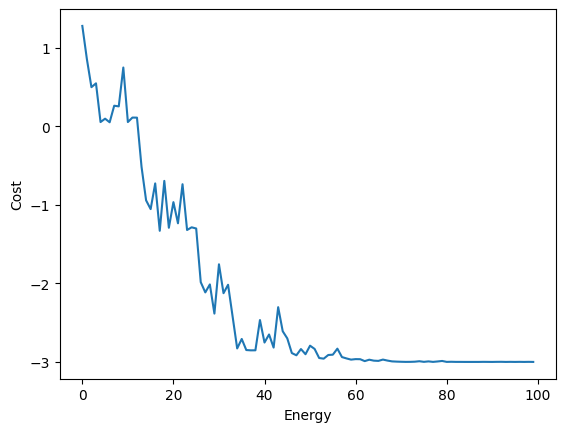

In [93]:
fig, ax = plt.subplots()
plt.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
plt.xlabel("Energy")
plt.ylabel("Cost")
plt.draw()

🎉 As expected our VQE algorithm minimized our Energy accross iterations, until reaching the ground state. We have now successfully implemented a VQE algorithm using brand new Qiskit 1.0 functionalities!

Thank you for completing this challenge, and good luck with the remaining ones!

# Additional information

<b>Created by:</b> James Weaver, Maria Gragera Garces

<b>Advisor:</b> Junye Huang

Version: 1.0